In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchsummary import summary
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
import numpy as np
import copy

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
# resnet was trained on images with values in specific range and not [-1, 1]
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # means and std for each channel, resnet was trained on 3 channel 224x224 images
                        ])

In [4]:
train_set = torchvision.datasets.STL10("../data", download=True, transform=transform, split="train")
test_set = torchvision.datasets.STL10("../data", download=True, transform=transform, split="test")

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(train_set), len(test_set)

(5000, 8000)

In [6]:
train_set[0][0].shape

torch.Size([3, 96, 96])

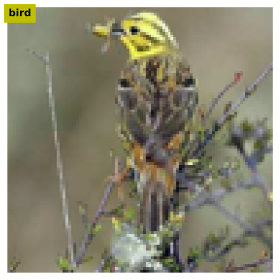

In [7]:
img = train_set[0][0].numpy().transpose((1, 2 ,0))
img = (img - np.min(img))
img = img/np.max(img)
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.imshow(img)
plt.text(0, 0, train_set.classes[train_set[0][1]], ha="left", va="top", fontweight="bold", color="k", backgroundcolor="y")
plt.axis("off")
plt.show()

In [8]:
train_data = torch.Tensor(np.array([x[0] for x in train_set]))
train_labels = torch.tensor(np.array([x[1] for x in train_set]), dtype=torch.long)
test_data = torch.Tensor(np.array([x[0] for x in test_set]))
test_labels = torch.tensor(np.array([x[1] for x in test_set]), dtype=torch.long)

In [9]:
np.unique(test_labels), train_set.classes

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 ['airplane',
  'bird',
  'car',
  'cat',
  'deer',
  'dog',
  'horse',
  'monkey',
  'ship',
  'truck'])

## Import resnet model

In [10]:
resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
resnet.eval()
with torch.no_grad():
    summary(resnet.to(device=device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [12]:
for p in resnet.parameters():
    p.requires_grad = False

In [13]:
summary(resnet.to(device=device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

#### As you can see trainable parameters are 0 after freezing all layers

In [14]:
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [15]:
resnet.fc = nn.Linear(512, 10)

In [16]:
resnet.to(device=device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=.001, momentum=.9)

In [18]:
summary(resnet.to(device=device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [19]:
train_ds = TensorDataset(train_data, train_labels)
test_ds = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [20]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [21]:
epochs = 10
train_acc, train_loss, test_acc, test_loss = [], [], [], []

for ei in range(epochs):
    resnet.train()
    batch_acc, batch_loss = [], []
    for x, y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        y_pred = resnet(x)
        loss = lossfunc(y_pred, y)
        acc = 100*torch.mean((torch.argmax(y_pred, axis=1)==y).float()).cpu().item()
        batch_acc.append(acc)
        batch_loss.append(loss.cpu().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del x, y
    train_acc.append(np.mean(batch_acc).item())
    train_loss.append(np.mean(batch_loss).item())
    resnet.eval()
    with torch.no_grad():
        x, y = next(iter(test_loader))
        x = x.to(device=device)
        y = y.to(device=device)
        y_test = resnet(x)
        test_acc.append(100*torch.mean((torch.argmax(y_test, axis=1)==y).float()).cpu().item())
        test_loss.append(lossfunc(y_test, y).cpu().item())
        del x, y
    print(f"Epoch: {ei}, Train Loss:{train_loss[-1]:.2f}, Test Loss: {test_loss[-1]:.2f}, Train Acc: {train_acc[-1]:.2f}, Test Acc: {test_acc[-1]:.2f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.39 GiB. GPU 0 has a total capacity of 7.78 GiB of which 2.34 GiB is free. Including non-PyTorch memory, this process has 5.43 GiB memory in use. Of the allocated memory 5.28 GiB is allocated by PyTorch, and 28.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)